# Basic setup

In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

from IPython.core.display import display, HTML
import simplejson as json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.options.display.float_format = '{:.2f}'.format
#-------------------------------------------------------------------------------------------------
# Just some helper functions
#-------------------------------------------------------------------------------------------------
def pretty_print_json(json_obj):
    print(json.dumps(json_obj, sort_keys = True, indent = 4 * ' '))

def pretty_print_dataframe(df):
    display(HTML(df.to_html()))

# Load data

In [ ]:
%%time

def get_price_range(row):
    if  'attributes' in row and \
        row['attributes'] is not None and \
            'RestaurantsPriceRange2' in row['attributes']:
        
        if row['attributes']['RestaurantsPriceRange2'] == 'None':
            return 0
        else:
            return int(row['attributes']['RestaurantsPriceRange2'])
    else:
        return 0

# No seperate field for identifying a restaurant.
# Doing an inspection of the data shows that the string
# "Restaurant" will appear in the categories array, however.
def is_restaurant(row):
    if 'categories' not in row \
        or row['categories'] is None:
            return False

    matches = [c for c in row['categories'].split(',') if c == 'Restaurants']
    return len(matches) > 0
#-------------------------------------------------------------------------------------------------
#$ cat yelp_academic_dataset_business.json | wc -l
#$ 209393
#$ cat yelp_academic_dataset_review.json | wc -l
#$ 8021122
#$ cat yelp_academic_dataset_tip.json | wc -l
#$ 1320761
#$ cat yelp_academic_dataset_user.json | wc -l
# 1968703

# Approx. 209k restaurants and 8M reviews. 
# Normally all this data would already be easy to access via a data lake.
# Many options here: EMR, Redshift, document DB, HDF5, Dask, more RAM, etc. 
# Really depends on what the volume of the real data is and resources.

DATA_BUSINESSES = 'yelp_academic_dataset_business.json'
DATA_REVIEWS = 'yelp_academic_dataset_review.json'
DATA_TIPS = 'yelp_academic_dataset_tip.json'
DATA_USERS = 'yelp_academic_dataset_user.json'

MAX_CHUNK = 50000
MAX_BUSINESSES = 250000
MAX_REVIEWS = 9000000
MAX_TIPS = 800000
MAX_USERS = 5000

print("Parsing a max of {} users".format(MAX_USERS))
print("Parsing a max of {} businesses".format(MAX_BUSINESSES))
print("Parsing a max of {} reviews".format(MAX_REVIEWS))
print("Parsing a max of {} tips".format(MAX_TIPS))
#-------------------------------------------------------------------------------------------------
# Some data loader helper functions. Lots of room to clean this and above up
# into classes and reduce code duplications - the loops are pretty much the
# same except for some minor filter logic.
#-------------------------------------------------------------------------------------------------
def load_users():
    users = []
    with pd.read_json(DATA_USERS,
                      nrows = MAX_USERS,
                      lines = True,
                      chunksize = min(MAX_USERS, MAX_CHUNK)) \
    as reader:
        for chunk in reader:
            parsed_chunk = json.loads(chunk.to_json(orient = 'index'))
            users += [row for key, row in parsed_chunk.items()]
    
    print("Loaded {} users".format(len(users)))
    return pd.DataFrame(users)

def load_restaurants():
    restaurants = []
    with pd.read_json(DATA_BUSINESSES,
                      nrows = MAX_BUSINESSES,
                      lines = True,
                      chunksize = min(MAX_BUSINESSES, MAX_CHUNK)) \
    as reader:
        for chunk in reader:
            parsed_chunk = json.loads(chunk.to_json(orient = 'index'))
            for key, row in parsed_chunk.items():
                # Restaurant that's open and has price range
                if is_restaurant(row) and get_price_range(row) and row['is_open']:
                    row['price_range'] = get_price_range(row)
                    restaurants.append(row)
    
    print("Loaded {} restuarants".format(len(restaurants)))
    return pd.DataFrame(restaurants)

def load_reviews(df_restaurants, only_useful = False, user_id = None):
    reviews = []
    with pd.read_json(DATA_REVIEWS,
                      nrows = MAX_REVIEWS,
                      lines = True,
                      chunksize = min(MAX_REVIEWS, MAX_CHUNK)) \
    as reader:
        for chunk in reader:
            parsed_chunk = json.loads(chunk.to_json(orient = 'index'))
            for key, row in parsed_chunk.items():
                # If we're limiting to one user and this
                # review isn't made by that one user, skip
                # this review
                if user_id and row['user_id'] != user_id:
                    continue
                
                # Does this review match any restaurant?
                if df_restaurants.business_id.isin([row['business_id']]).any():                    
                    # Any review or just useful ones?
                    if only_useful and row['useful'] > 0:
                        reviews.append(row)
                    else:
                        reviews.append(row)

    df_reviews = pd.DataFrame(reviews)

    print("Loaded {} reviews".format(len(df_reviews)))
    return df_reviews

def load_tips(df_restaurants, df_users, user_id, business_id):
    if user_id and business_id:
        raise ValueError("Please provide a user ID or business ID, not both.")
    
    tips = []
    with pd.read_json(DATA_TIPS,
                      nrows = MAX_TIPS,
                      lines = True,
                      chunksize = min(MAX_TIPS, MAX_CHUNK)) \
    as reader:
        for chunk in reader:
            parsed_chunk = json.loads(chunk.to_json(orient = 'index'))
            for key, row in parsed_chunk.items():
                if business_id:
                    if df_restaurants.business_id.isin([row['business_id']]).any():
                        tips.append(row)
                else:
                    if df_users.user_id.isin([row['user_id']]).any():
                        tips.append(row)
    
    print("Loaded {} tips".format(len(tips)))
    return pd.DataFrame(tips)
#-------------------------------------------------------------------------------------------------
#df_users = load_users()
#pretty_print_dataframe(df_users.drop(columns=['friends']).head(10))
#df_users.to_pickle("./users.pkl")

#pretty_print_dataframe(df_tips.head(10))
#df_tips.to_pickle("./tips.pkl")

df_restaurants = load_restaurants()
pretty_print_dataframe(df_restaurants.head(5))
df_restaurants.to_pickle("./restaurants.pkl", protocol = 4)

df_useful_reviews = load_reviews(df_restaurants, only_useful = True)
pretty_print_dataframe(df_useful_reviews.head(5))
df_useful_reviews.to_pickle("./useful_reviews.pkl", protocol = 4)
# Wall time: 57min 43s just for reviews

#display(HTML(df_reviews.to_html()))

In [2]:
%%time
# Once you run above once you can just skip to this cell to load the data you want quickly
BASE_PATH = '/home/ubuntu/'
#df_restaurants = pd.read_pickle(BASE_PATH + 'restaurants.pkl')
#df_reviews = pd.read_pickle(BASE_PATH + 'useful_reviews.pkl')
df_reviews = pd.read_pickle('all_useful_reviews_tokenized_w_sentiment.pkl')

#df_users = pd.read_pickle(BASE_PATH + 'users.pkl')
#df_tips = pd.read_pickle(BASE_PATH + 'tips.pkl')

print(f"There are {len(df_reviews)} reviews.")
#print(f"There are {len(df_restaurants)} restaurants.")

There are 1018657 reviews.
CPU times: user 10 s, sys: 2.5 s, total: 12.5 s
Wall time: 14.3 s


# Exploratory Data Analysis

count   7461.00
mean     136.53
std      219.01
min        5.00
25%       25.00
50%       63.00
75%      155.00
max     3816.00
Name: business_id, dtype: float64


<AxesSubplot:>

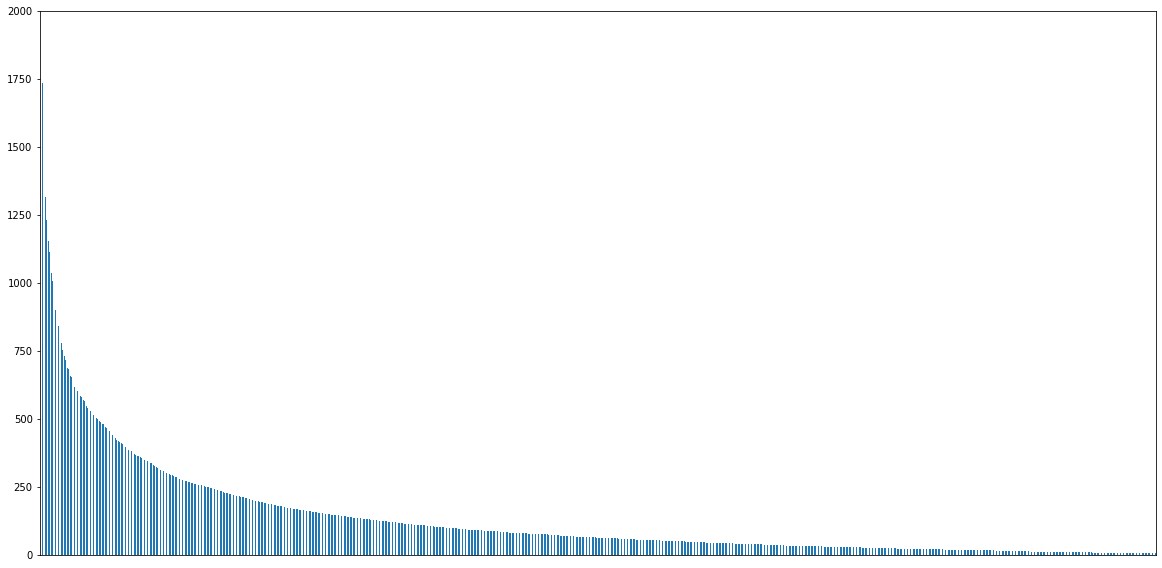

In [6]:
# Let's take a look at reviews per restaurant
tmp = df_reviews.business_id.value_counts()
print(tmp.describe())
# 9536    max reviews for a restaurant
# 3       min reviews for a restaurant
# 13      25% percentile: one-quarter of restaurants in data have less than 15 reviews
# 36      50% percentile: half of restaurants in data have less than 40 reviews
# 100     75% percentile: three-quarters of restaurants in the data have less than 100 reviews

# X=business_id; Y=# of reviews
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
ax1.set_ylim([0, 2000])

tmp.plot.bar(figsize = (20, 10))

# We may want to filter out any restaurant with less than, say, 5 reviews
# but for sake of this demo and time constraints I'll just leave them all
# in here. There's no technical reason those reviews are any worse.

Review length stats:
count   1018657.00
mean        556.92
std         511.31
min           1.00
25%         224.00
50%         398.00
75%         712.00
85%         955.00
95%        1535.00
max        5000.00
Name: length, dtype: float64


,useful,funny,cool,length
stars,,,,
1,1.09,0.48,0.16,626.37
2,1.11,0.47,0.28,685.57
3,0.97,0.42,0.46,664.47
4,1.00,0.40,0.64,589.37
5,0.77,0.27,0.47,455.82


,useful,funny,cool,length
useful,1.00,0.98,-0.51,0.87
funny,0.98,1.00,-0.57,0.92
cool,-0.51,-0.57,1.00,-0.38
length,0.87,0.92,-0.38,1.00


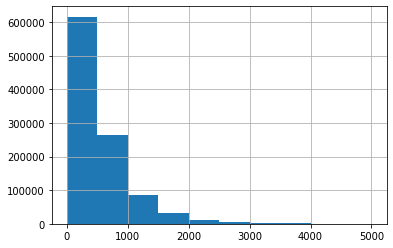

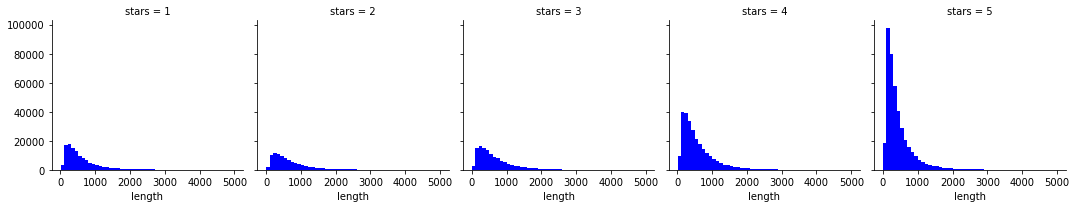

In [11]:
# Add dimension of review length
df_reviews['length'] = df_reviews['text'].apply(len)
print('Review length stats:')
print(df_reviews['length'].describe(percentiles = [.25, .5, .75, .85, .95]))
df_reviews['length'].hist()

stars_to_votes = df_reviews.groupby('stars').mean()
stars_to_votes.drop(columns = ['date'], inplace = True)

# Avgs of votes for {useful, funny, cool} relative to stars
pretty_print_dataframe(stars_to_votes)
# Correlation between how a review is marked and stars
pretty_print_dataframe(stars_to_votes.corr())

# Cool: negative corr to length and funny, weak corr to useful
# Useful: strong corr to funny and length

# Now, let's see if there's some corr between higher ratings and length
graph = sns.FacetGrid(data = df_reviews, col = 'stars')
graph.map(plt.hist, 'length' , bins = 50, color = 'blue')

# Clean and tokenize reviews

#### Define single and batch text cleaning and tokenization functions

In [3]:
%%time
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

nlp = spacy.load('en_core_web_sm')
ignored = ['PUNCT', 'SYM']

def clean(text):
    # Remove punctuation, symbols, and stopwords. Then lowercase...
    tmp = [tok.lower_ for tok in nlp(text, disable = ['ner', 'parser', 'lemmatizer']) \
           if (tok.text not in stopwords and tok.pos_ not in ignored)]
    tmp = [t.replace('\n', ' ') for t in tmp]
    
    return tmp

def clean_batch(texts):
    # Remove punctuation, symbols, and stopwords. Then lowercase...
    tok_texts = []
    for doc in nlp.pipe(texts, disable = ['ner', 'parser', 'lemmatizer']):
        tmp = [tok.lower_ for tok in doc if (tok.text not in stopwords and tok.pos_ not in ignored)]
        tmp = [t.replace('\n', ' ') for t in tmp]
        
        tok_texts.append(tmp)
    
    return tok_texts

CPU times: user 562 ms, sys: 77.8 ms, total: 640 ms
Wall time: 1.11 s


#### Modify dataframe to include tokenized version of text

In [ ]:
df_reviews_subset = df_reviews #df_reviews.loc[0:100, :]
df_reviews_subset['tokenized'] = clean_batch(df_reviews_subset['text'])
print(df_reviews_subset['tokenized'].head(10))

#### Persist tokenized reviews to save time in future 

In [ ]:
pretty_print_dataframe(df_reviews_subset.head(5))
df_reviews_subset.to_pickle("./all_useful_reviews_tokenized.pkl", protocol = 4)

# Assign sentiment to reviews

In [ ]:
# Loaded pickled version of reviews may be a subset.
# Use this to avoid having to make code changes below.
df_reviews_subset = df_reviews

# 1 or 2 stars => negative review
df_reviews_subset.loc[df_reviews_subset['stars'] < 3, 'sentiment'] = 'neg'
# 3 => "middle of road", neutral review
df_reviews_subset.loc[df_reviews_subset['stars'] == 3, 'sentiment'] = 'neu'
# 4 or 5 stars => positive review
df_reviews_subset.loc[df_reviews_subset['stars'] > 3, 'sentiment'] = 'pos'

df_reviews_subset.to_pickle("./all_useful_reviews_tokenized_w_sentiment.pkl", protocol = 4)
#pretty_print_dataframe(df_reviews_subset[['stars', 'text', 'sentiment']][:10])

count        3.00
mean    339552.33
std     298546.68
min     127289.00
25%     168866.00
50%     210443.00
75%     445684.00
max     680925.00
Name: sentiment, dtype: float64


<AxesSubplot:>

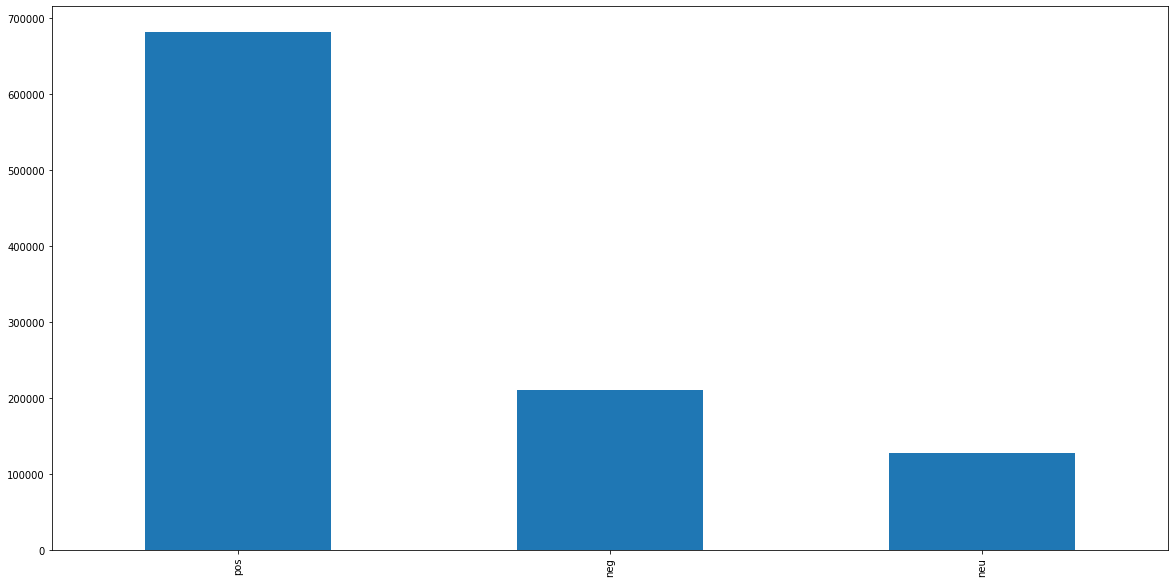

In [17]:
# It's clear there are more positive reviews than both neutral or negative.
# This skew will hurt our classifier, so let us resample.

tmp = df_reviews_subset.sentiment.value_counts()
print(tmp.describe())
tmp.plot.bar(figsize = (20, 10))

680925 pos | 127289 neu | 210443 neg -> min class has 127289 reviews, max class has 680925 reviews.


<AxesSubplot:>

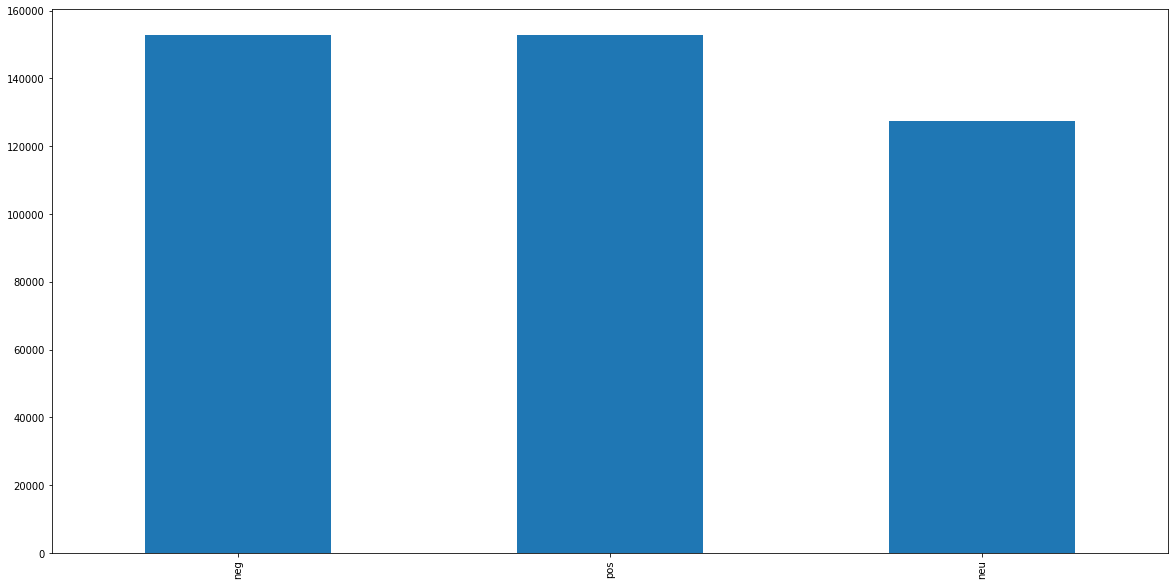

In [140]:
df_reviews_subset = df_reviews

pos = df_reviews_subset[df_reviews_subset['sentiment'] == 'pos']
neu = df_reviews_subset[df_reviews_subset['sentiment'] == 'neu']
neg = df_reviews_subset[df_reviews_subset['sentiment'] == 'neg']

min_class = min(len(neg), len(neu), len(pos))
max_class = max(len(neg), len(neu), len(pos))

print(f"{len(pos)} pos | {len(neu)} neu | {len(neg)} neg -> min class has {min_class} reviews, max class has {max_class} reviews.")

from sklearn.utils import resample
#--------------------------------------------------------------------------------
# Option 1: downsample from larger classes
max_rows = int(min_class * 1.2)

df_pos_review_downsampled = resample(pos,
                                     replace = False,
                                     n_samples = max_rows,
                                     random_state = 42)

df_neg_review_downsampled = resample(neg,
                                     replace = False,
                                     n_samples = max_rows,
                                     random_state = 42)

# Recombine
df_reviews_final = pd.concat([df_neg_review_downsampled.iloc[0:max_rows, :], neu, df_pos_review_downsampled.iloc[0:max_rows, :]])
#-------------------------------------------------------------------------------
# Option 2: upsample from smaller classes
# df_neg_review_upsampled = resample(neg,
#                                    replace = True,
#                                    n_samples = max_class,
#                                    random_state = 42)

# df_neu_review_upsampled = resample(neu,
#                                    replace = True,
#                                    n_samples = max_class,
#                                    random_state = 42)

# Recombine
# max_rows = max_class
# df_reviews_final = pd.concat([df_neg_review_upsampled.iloc[0:max_rows, :], df_neu_review_upsampled.iloc[0:max_rows, :], pos.iloc[0:max_rows, :]])
#--------------------------------------------------------------------------------
tmp = df_reviews_final.sentiment.value_counts()
tmp.plot.bar(figsize = (20, 10))

### Last change to trim data set

In [ ]:
from sklearn.utils import shuffle
df_reviews_final.reset_index(inplace = True, drop = True)
df_reviews_final = df_reviews_final.iloc[:100000, :]

### Extract features

In [141]:
%%time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def echo_function(doc):
    return doc

#list_corpus = df_reviews_final['tokenized'].tolist()
#
# Use this instead of above if you're going to 
# let sklearn tokenize for you
list_corpus = df_reviews_final['text'].tolist()

list_labels = df_reviews_final['sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size = 0.2, random_state = 42)

# Use Spacy's tokenization
# vec = TfidfVectorizer(tokenizer = echo_function,
#                       preprocessor = echo_function,
#                       token_pattern = None,
#                       ngram_range = (1, 2),
#                       min_df = 0.05,
#                       max_df = 0.6,
#                       sublinear_tf = False,
#                       max_features = 350,
#                       analyzer = 'word')

# Let sklearn tokenize
vec = TfidfVectorizer(tokenizer = None,
                      preprocessor = None,
                      ngram_range = (1, 2),
                      min_df = 0.01,
                      max_df = 0.90,
                      sublinear_tf = False,
                      max_features = 350,
                      analyzer = 'word')

# vec = CountVectorizer(tokenizer = echo_function,
#                       preprocessor = echo_function,
#                       token_pattern = None,
#                       ngram_range = (1, 2),
#                       min_df = 100,
#                       max_features = 350,
#                       analyzer = 'word')

# Last 4 vectorizer settings need to be on grid search
X_train_counts = vec.fit_transform(X_train)
X_test_counts = vec.transform(X_test)

CPU times: user 1min 3s, sys: 1.26 s, total: 1min 4s
Wall time: 1min 4s


# Visualize

TF-IDF matrix: (305493, 158)
Non-zeros: 5038028
Matrix density: 10.44%


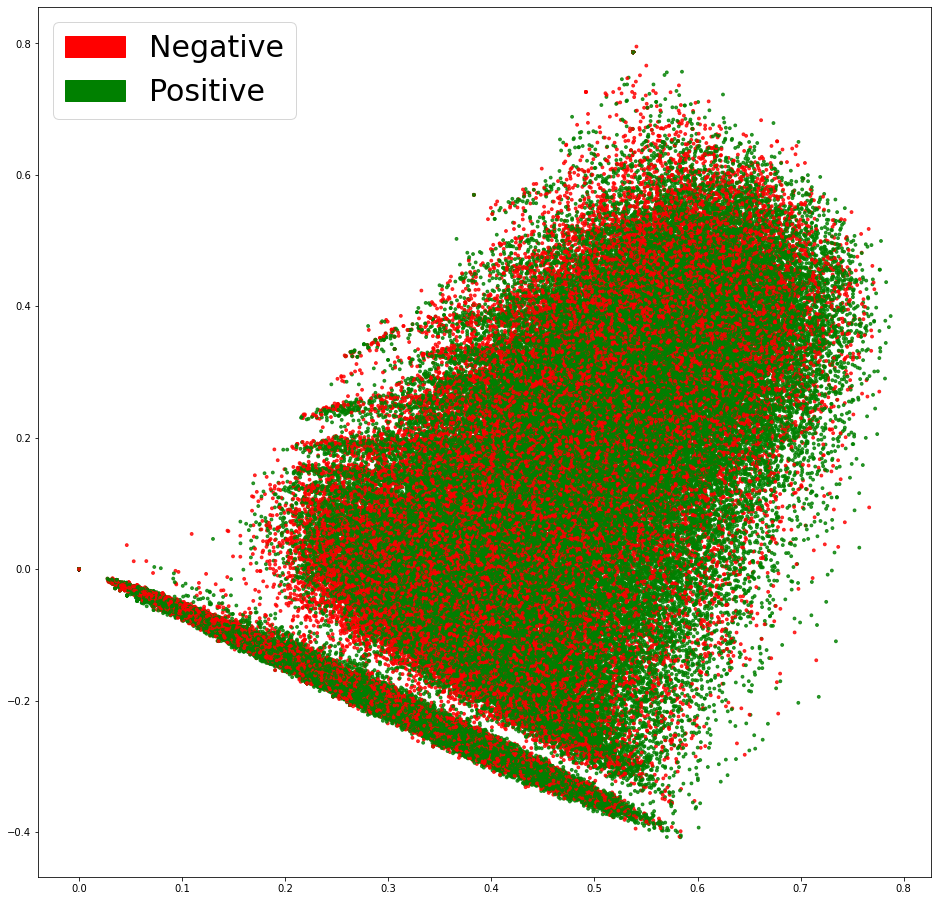

In [100]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing


print(f"TF-IDF matrix: {X_train_counts.shape}")
print(f"Non-zeros: {X_train_counts.nnz}")
density = (X_train_counts.nnz / (X_train_counts.shape[0] * X_train_counts.shape[1])) * 100
print(f"Matrix density: {density:.2f}%")

def plot_LSA(test_data, test_labels):
        lsa = TruncatedSVD(n_components = 2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        #print("LSA scores: {}".format(lsa_scores))
        
        color_mapper = {label:idx for idx, label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red', 'green']
        
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s = 8, alpha = 0.8, \
                    c = test_labels, cmap = matplotlib.colors.ListedColormap(colors))
        
        red_patch = mpatches.Patch(color = 'red', label = 'Negative')
        green_patch = mpatches.Patch(color = 'green', label = 'Positive')

        plt.legend(handles=[red_patch, green_patch], prop = {'size': 30})

def plot_tsne(test_data, test_labels):
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(test_data)

    df_data = pd.DataFrame()
    df_data['tsne-one'] = tsne_results[:, 0]
    df_data['tsne-two'] = tsne_results[:, 1]

    sns.scatterplot(
        x = "tsne-one", y = "tsne-two",
        palette = sns.color_palette("hls", 10),
        data = df_data,
        legend = "full",
        alpha = 0.3)

le = preprocessing.LabelEncoder()
le.fit(y_train)

fig = plt.figure(figsize=(16, 16))

plot_LSA(X_train_counts, le.transform(y_train))
#plot_tsne(X_train_counts, le.transform(y_train))
plt.show()

# Build model

In [142]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def show_metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')    
    f1 = f1_score(y_test, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

#--------------------------------------------
# clf = MultinomialNB()
# clf.fit(X_train_counts, y_train)
# y_hat = clf.predict(X_test_counts)
# show_metrics(y_test, y_hat)
#--------------------------------------------
clf = LogisticRegression(C = 1.0,
                         multi_class = 'auto',
                         max_iter = 5000,
                         random_state = 42)

clf.fit(X_train_counts, y_train)
y_hat = clf.predict(X_test_counts)
show_metrics(y_test, y_hat)
#--------------------------------------------
# clf = DecisionTreeClassifier()
# clf.fit(X_train_counts, y_train)
# y_hat = clf.predict(X_test_counts)
# show_metrics(y_test, y_hat)
#--------------------------------------------
# Warning: slow
# clf = RandomForestClassifier()
# clf.fit(X_train_counts, y_train)
# y_hat = clf.predict(X_test_counts)
# show_metrics(y_test, y_hat)
#--------------------------------------------
# Warning: slow
# clf = SVC(kernel = 'linear',
#           class_weight = 'balanced',
#           probability = True)

# clf.fit(X_train_counts, y_train)
# y_hat = clf.predict(X_test_counts)
# show_metrics(y_test, y_hat)

# Baseline model
# multinomial nb: 
#--------------------------------------------------------------------------------------------
# log-reg: accuracy = 0.709, precision = 0.705, recall = 0.709, f1 = 0.706
#--------------------------------------------------------------------------------------------
# decision tree: accuracy = 0.527, precision = 0.527, recall = 0.527, f1 = 0.527
#--------------------------------------------------------------------------------------------
# random forest: took too long
#--------------------------------------------------------------------------------------------
# SVC with 15k in each class: accuracy = 0.523, precision = 0.529, recall = 0.523, f1 = 0.520 (~7.5mins)

accuracy = 0.709, precision = 0.705, recall = 0.709, f1 = 0.706
CPU times: user 27.4 s, sys: 20 ms, total: 27.4 s
Wall time: 27.4 s


# Analyze model results

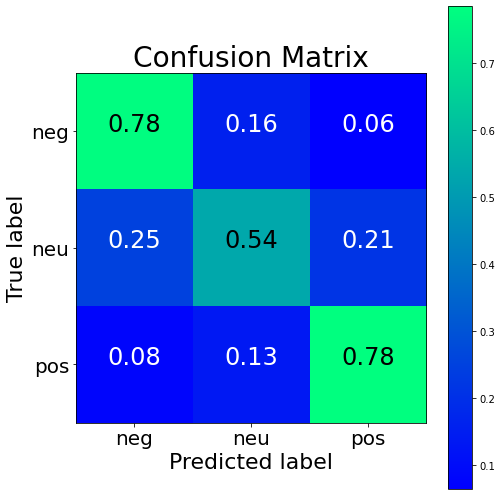

[[23649  4806  1974]
 [ 6406 13816  5412]
 [ 2489  4090 23915]]


In [143]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.winter)
    plt.title('Confusion Matrix', fontsize = 28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 24)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 22)
    plt.xlabel('Predicted label', fontsize = 22)

    return plt

cm = confusion_matrix(y_test, y_hat)
fig = plt.figure(figsize = (7, 7))
plot = plot_confusion_matrix(cm, classes = ['neg', 'neu', 'pos'])
plt.show()
print(cm)

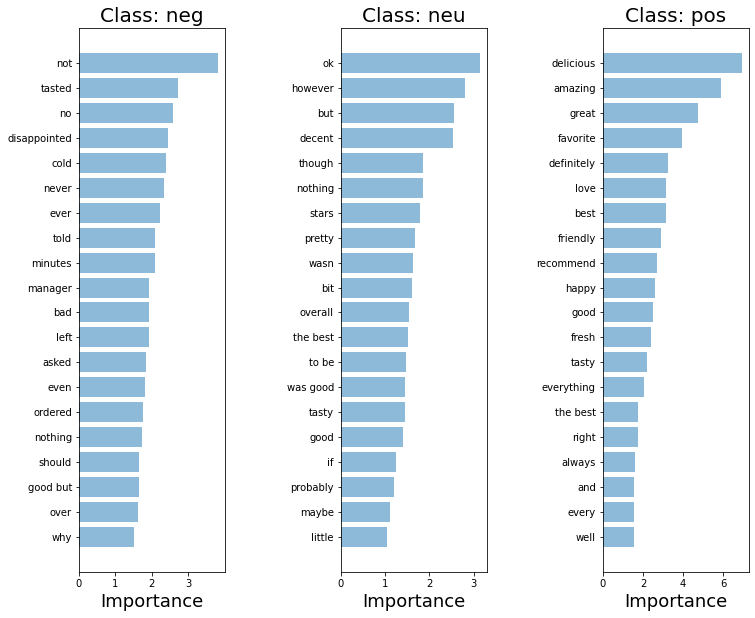

In [144]:
def get_most_important_features(vectorizer, model, n = 5):
    index_to_word = {v:k for k, v in vectorizer.vocabulary_.items()}
    
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse = True)
        top = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'top': top,
            'bottom': bottom
        }
        
    return classes

importance = get_most_important_features(vec, clf, 20)
num_classes = clf.coef_.shape[0]
fig, ax = plt.subplots(nrows = 1, ncols = num_classes, figsize = (12, 10))

class_labels = ['neg', 'neu', 'pos']

for class_index in range(num_classes):
    top_scores = [a[0] for a in importance[class_index]['top']]
    top_words = [a[1] for a in importance[class_index]['top']]

    bottom_scores = [a[0] for a in importance[class_index]['bottom']]
    bottom_words = [a[1] for a in importance[class_index]['bottom']]
    
    y_pos = np.arange(len(top_words))
    ax[class_index].barh(y_pos, top_scores, tick_label = top_words ,align = 'center', alpha = 0.5)
    ax[class_index].set_title("Class: {}".format(class_labels[class_index]), fontsize = 20)
    ax[class_index].set_xlabel('Importance', fontsize = 18)


plt.subplots_adjust(wspace = 0.8)
plt.show()

In [145]:
def predict_sentiment(review):
    tokenized_review = clean(review)
    review_token_counts = vec.transform(tokenized_review)

    pred = clf.predict(review_token_counts)
    values, counts = np.unique(pred, return_counts = True)

    return values[counts.argmax()]

# Random smattering of results...
import random
for i in range(5):
    rnd = random.randrange(20)
    random_review = df_reviews_subset.iloc[rnd]
    pred_sentiment = predict_sentiment(random_review['text'])
    print("-" * 50)
    print(f"Idx: {rnd}")
    print(f"Known sentiment: {random_review['sentiment']}")
    print(f"Predicted sentiment: {sentiment}")

        
print("done")

152746
--------------------------------------------------
Idx: 9
Known sentiment: neg
Predicted sentiment: neg
--------------------------------------------------
Idx: 1
Known sentiment: pos
Predicted sentiment: neg
--------------------------------------------------
Idx: 8
Known sentiment: neu
Predicted sentiment: neg
--------------------------------------------------
Idx: 13
Known sentiment: neg
Predicted sentiment: neg
--------------------------------------------------
Idx: 7
Known sentiment: pos
Predicted sentiment: neg
done


### Save model and vectorizer to deploy

In [146]:
import pickle
pickle.dump(clf, open('sentiment_clf.pkl', 'wb'), protocol = 4)
pickle.dump(vec, open('sentiment_vec.pkl', 'wb'), protocol = 4)